<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVP-SprintI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint I: Análise de Dados e Boas Práticas (40530010055_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Maio/2023

# **Introdução**

## Programa para obtenção do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)


> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS). 

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

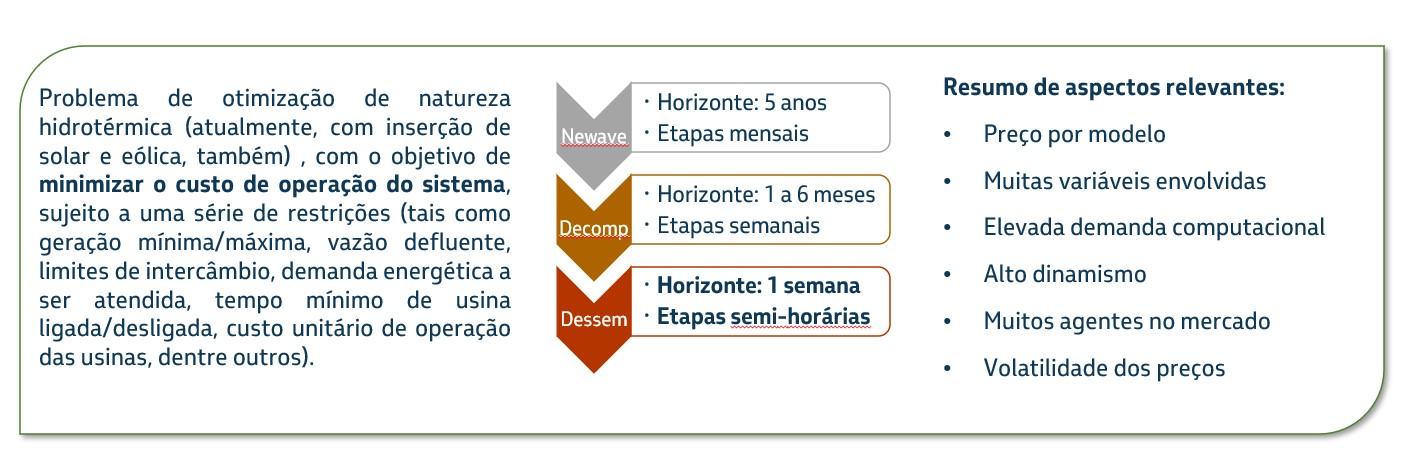

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

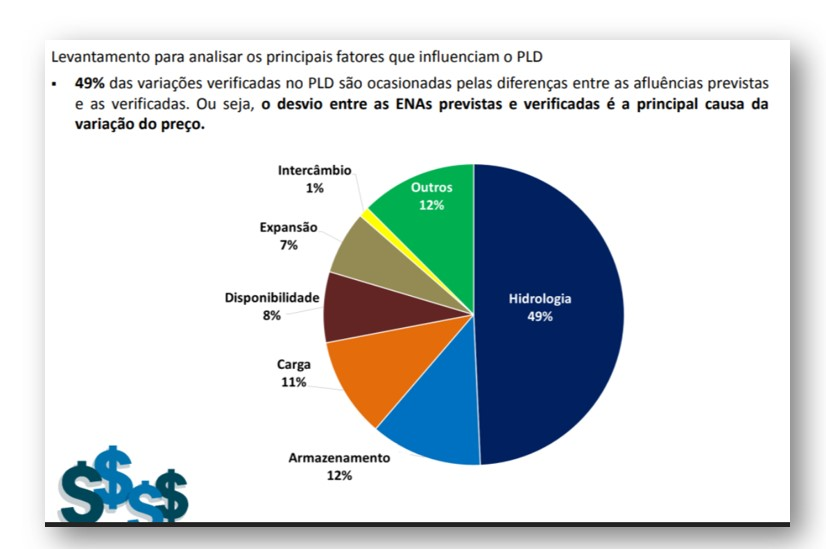

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [328]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot) e datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#
## Transformações Numéricas
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

Qual a novidade ou história sobre esses conjuntos de dados? a ENA é uma informação de grande relevância para os estudos energéticos que já era disponibilizada pelo ONS em uma série de produtos diários, semanais e mensais. Agora todo os dados estão sendo divulgados de forma estruturada, organizada em todas as visões.

In [329]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-04-28 00:06:34.073797
2023


In [330]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
475            SE        SUDESTE  2023-04-29            52427.855469   
476             N          NORTE  2023-04-30            24056.681641   
477            NE       NORDESTE  2023-04-30             4425.798828   
478             S            SUL  2023-04-30             5107.930176   
479            SE        SUDESTE  2023-04-30            51253.191406   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [331]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

,id_subsistema,nom_subsistema,ena_data,ena_bruta_regiao_mwmed,ena_bruta_regiao_percentualmlt,ena_armazenavel_regiao_mwmed,ena_armazenavel_regiao_percentualmlt
0,N,NORTE,2001-01-01,10154.0,122.339996,9033.0,108.839996
1,NE,NORDESTE,2001-01-01,13472.0,101.480003,13385.0,100.830002
2,S,SUL,2001-01-01,7703.0,160.910004,7703.0,160.910004
3,SE,SUDESTE,2001-01-01,39186.0,86.980003,37611.0,83.489998
4,N,NORTE,2001-01-02,9590.0,115.550003,8091.0,97.489998
5,NE,NORDESTE,2001-01-02,13551.0,102.080002,13465.0,101.430000
6,S,SUL,2001-01-02,6730.0,140.580002,6730.0,140.580002
7,SE,SUDESTE,2001-01-02,41230.0,91.519997,40063.0,88.930000
8,N,NORTE,2001-01-03,9066.0,109.239998,7213.0,86.910004
9,NE,NORDESTE,2001-01-03,13551.0,102.080002,13461.0,101.400002


In [332]:
# Conferindo as últimas 10 linhas
ena.tail(10)

,id_subsistema,nom_subsistema,ena_data,ena_bruta_regiao_mwmed,ena_bruta_regiao_percentualmlt,ena_armazenavel_regiao_mwmed,ena_armazenavel_regiao_percentualmlt
470,S,SUL,2023-04-28,6023.563965,92.598503,5882.439941,90.429001
471,SE,SUDESTE,2023-04-28,53677.875000,98.041298,39171.996094,71.546700
472,N,NORTE,2023-04-29,24459.800781,90.699898,17497.197266,64.881699
473,NE,NORDESTE,2023-04-29,4433.688965,38.581200,4422.963867,38.487900
474,S,SUL,2023-04-29,5535.545898,85.096298,5180.103027,79.632202
475,SE,SUDESTE,2023-04-29,52427.855469,95.758202,35085.000000,64.081902
476,N,NORTE,2023-04-30,24056.681641,89.205101,16727.423828,62.027302
477,NE,NORDESTE,2023-04-30,4425.798828,38.512600,4407.208984,38.350800
478,S,SUL,2023-04-30,5107.930176,78.522697,4844.619141,74.474899
479,SE,SUDESTE,2023-04-30,51253.191406,93.612701,32486.623047,59.335999


In [333]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8155.0

In [334]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [335]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [336]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
475            SE        Sudeste  2023-04-29            52427.855469   
476             N          Norte  2023-04-30            24056.681641   
477            NE       Nordeste  2023-04-30             4425.798828   
478             S            Sul  2023-04-30             5107.930176   
479            SE        Sudeste  2023-04-30            51253.191406   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [337]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [338]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [339]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

,id_subsistema,nom_subsistema,Data,ena_bruta_regiao_mwmed,ena_bruta_regiao_percentualmlt,ena_armazenavel_regiao_mwmed,ena_armazenavel_regiao_percentualmlt
479,SE,Sudeste,2023-04-30,51253.191406,93.612701,32486.623047,59.335999
478,S,Sul,2023-04-30,5107.930176,78.522697,4844.619141,74.474899
477,NE,Nordeste,2023-04-30,4425.798828,38.512600,4407.208984,38.350800
476,N,Norte,2023-04-30,24056.681641,89.205101,16727.423828,62.027302
475,SE,Sudeste,2023-04-29,52427.855469,95.758202,35085.000000,64.081902
474,S,Sul,2023-04-29,5535.545898,85.096298,5180.103027,79.632202
473,NE,Nordeste,2023-04-29,4433.688965,38.581200,4422.963867,38.487900
472,N,Norte,2023-04-29,24459.800781,90.699898,17497.197266,64.881699
471,SE,Sudeste,2023-04-28,53677.875000,98.041298,39171.996094,71.546700
470,S,Sul,2023-04-28,6023.563965,92.598503,5882.439941,90.429001


## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

Qual a novidade ou história sobre esses conjuntos de dados? a EAR é uma informação de grande relevância para os estudos energéticos e que já era disponibilizada pelo ONS em uma série de produtos diários, semanais e mensais. Agora todo os dados estão sendo divulgados de forma estruturada, organizada em todas as visões.

In [340]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
475             S            SUL  2023-04-29        20459.242188   
476            NE       NORDESTE  2023-04-30        51691.226562   
477             N          NORTE  2023-04-30        15302.396484   
478            SE        SUDESTE  2023-04-30       204615.328125   
479             S            SUL  2023-04-30        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [341]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

,id_subsistema,nom_subsistema,ear_data,ear_max_subsistema,ear_verif_subsistema_mwmes,ear_verif_subsistema_percentual
0,NE,NORDESTE,2001-01-01,49967.0,18699.0,37.419998
1,N,NORTE,2001-01-01,12311.0,9137.0,74.220001
2,SE,SUDESTE,2001-01-01,159081.0,46315.0,29.110001
3,S,SUL,2001-01-01,14176.0,12857.0,90.690002
4,NE,NORDESTE,2001-01-02,49967.0,18851.0,37.730000
5,N,NORTE,2001-01-02,12311.0,9327.0,75.760002
6,SE,SUDESTE,2001-01-02,159081.0,46850.0,29.450001
7,S,SUL,2001-01-02,14176.0,12920.0,91.139999
8,NE,NORDESTE,2001-01-03,49967.0,19047.0,38.119999
9,N,NORTE,2001-01-03,12311.0,9453.0,76.779999


In [342]:
# Conferindo as últimas 10 linhas
earm.tail(10)

,id_subsistema,nom_subsistema,ear_data,ear_max_subsistema,ear_verif_subsistema_mwmes,ear_verif_subsistema_percentual
470,SE,SUDESTE,2023-04-28,204615.328125,176349.125000,86.185699
471,S,SUL,2023-04-28,20459.242188,17183.640625,83.989601
472,NE,NORDESTE,2023-04-29,51691.226562,47016.683594,90.956802
473,N,NORTE,2023-04-29,15302.396484,15004.389648,98.052597
474,SE,SUDESTE,2023-04-29,204615.328125,176283.828125,86.153801
475,S,SUL,2023-04-29,20459.242188,17177.837891,83.961304
476,NE,NORDESTE,2023-04-30,51691.226562,46988.765625,90.902802
477,N,NORTE,2023-04-30,15302.396484,15059.340820,98.411697
478,SE,SUDESTE,2023-04-30,204615.328125,176361.671875,86.191803
479,S,SUL,2023-04-30,20459.242188,17191.603516,84.028503


In [343]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8155.0

In [344]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [345]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [346]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
475             S            Sul  2023-04-29        20459.242188   
476            NE       Nordeste  2023-04-30        51691.226562   
477             N          Norte  2023-04-30        15302.396484   
478            SE        Sudeste  2023-04-30       204615.328125   
479             S            Sul  2023-04-30        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [347]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [348]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [349]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

,id_subsistema,nom_subsistema,Data,ear_max_subsistema,ear_verif_subsistema_mwmes,ear_verif_subsistema_percentual
479,S,Sul,2023-04-30,20459.242188,17191.603516,84.028503
478,SE,Sudeste,2023-04-30,204615.328125,176361.671875,86.191803
477,N,Norte,2023-04-30,15302.396484,15059.340820,98.411697
476,NE,Nordeste,2023-04-30,51691.226562,46988.765625,90.902802
475,S,Sul,2023-04-29,20459.242188,17177.837891,83.961304
474,SE,Sudeste,2023-04-29,204615.328125,176283.828125,86.153801
473,N,Norte,2023-04-29,15302.396484,15004.389648,98.052597
472,NE,Nordeste,2023-04-29,51691.226562,47016.683594,90.956802
471,S,Sul,2023-04-28,20459.242188,17183.640625,83.989601
470,SE,Sudeste,2023-04-28,204615.328125,176349.125000,86.185699


## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [350]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
475            SE  Sudeste/Centro-Oeste   2023-04-29                    NaN
476             N                 Norte   2023-04-30                    NaN
477            NE              Nordeste   2023-04-30                    NaN
478             S                   Sul   2023-04-30                    NaN
479            SE  Sudeste/Centro-Oeste   2023-04-30                    NaN

[32621 rows x 4 columns]


In [351]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

,id_subsistema,nom_subsistema,din_instante,val_cargaenergiamwmed
0,N,Norte,2001-01-01,2376.731250
1,NE,Nordeste,2001-01-01,5035.816667
2,S,Sul,2001-01-01,4925.373750
3,SE,Sudeste/Centro-Oeste,2001-01-01,19729.233333
4,N,Norte,2001-01-02,2537.383333
5,NE,Nordeste,2001-01-02,5946.387500
6,S,Sul,2001-01-02,6779.687500
7,SE,Sudeste/Centro-Oeste,2001-01-02,24596.195417
8,N,Norte,2001-01-03,2540.345833
9,NE,Nordeste,2001-01-03,6188.104167


In [352]:
# Conferindo as últimas 10 linhas
carga.tail(10)

,id_subsistema,nom_subsistema,din_instante,val_cargaenergiamwmed
470,S,Sul,2023-04-28,NaN
471,SE,Sudeste/Centro-Oeste,2023-04-28,NaN
472,N,Norte,2023-04-29,NaN
473,NE,Nordeste,2023-04-29,NaN
474,S,Sul,2023-04-29,NaN
475,SE,Sudeste/Centro-Oeste,2023-04-29,NaN
476,N,Norte,2023-04-30,NaN
477,NE,Nordeste,2023-04-30,NaN
478,S,Sul,2023-04-30,NaN
479,SE,Sudeste/Centro-Oeste,2023-04-30,NaN


In [353]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8155.25

In [354]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
...            ...                   ...                  ...   
475             SE  Sudeste/Centro-Oeste           2023-04-29   
476              N                 Norte           2023-04-30   
477             NE              Nordeste           2023-04-30   
478              S                   Sul           2023-04-30   
479             SE  Sudeste/Centro-Oeste           2023-04-30   

      val_cargaenergiamwmed  
132                     NaN  
1337                    NaN  
1338                    NaN  
1339                    NaN  
1340                    NaN  
...                     ...  
475      

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [355]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [356]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [357]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
475            SE        Sudeste  2023-04-29                    NaN
476             N          Norte  2023-04-30                    NaN
477            NE       Nordeste  2023-04-30                    NaN
478             S            Sul  2023-04-30                    NaN
479            SE        Sudeste  2023-04-30                    NaN

[32621 rows x 4 columns]


In [358]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [359]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [360]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

,id_subsistema,nom_subsistema,Data,val_cargaenergiamwmed
479,SE,Sudeste,2023-04-30,NaN
478,S,Sul,2023-04-30,NaN
477,NE,Nordeste,2023-04-30,NaN
476,N,Norte,2023-04-30,NaN
475,SE,Sudeste,2023-04-29,NaN
474,S,Sul,2023-04-29,NaN
473,NE,Nordeste,2023-04-29,NaN
472,N,Norte,2023-04-29,NaN
471,SE,Sudeste,2023-04-28,NaN
470,S,Sul,2023-04-28,NaN


## Custo Marginal da Operação (CMO)

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível. 




In [361]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)  
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

   id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0              N          NORTE   2005-01-07                 0.94   
1             NE       NORDESTE   2005-01-07                 0.94   
2              S            SUL   2005-01-07                 4.50   
3             SE        SUDESTE   2005-01-07                 0.00   
4              N          NORTE   2005-01-14                 6.34   
..           ...            ...          ...                  ...   
67            SE        SUDESTE   2023-04-28                 0.00   
68             N          NORTE   2023-05-05                 0.00   
69            NE       NORDESTE   2023-05-05                 0.00   
70             S            SUL   2023-05-05                 0.00   
71            SE        SUDESTE   2023-05-05                 0.00   

    val_cmoleve  val_cmomedia  val_cmopesada  
0          0.94          0.94           0.94  
1          0.94          0.94           0.94  
2          4.39          4.59 

In [362]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

,id_subsistema,nom_subsistema,din_instante,val_cmomediasemanal,val_cmoleve,val_cmomedia,val_cmopesada
0,N,NORTE,2005-01-07,0.94,0.94,0.94,0.94
1,NE,NORDESTE,2005-01-07,0.94,0.94,0.94,0.94
2,S,SUL,2005-01-07,4.50,4.39,4.59,4.59
3,SE,SUDESTE,2005-01-07,0.00,0.00,0.00,0.00
4,N,NORTE,2005-01-14,6.34,5.87,6.41,7.64
5,NE,NORDESTE,2005-01-14,7.64,7.64,7.64,7.64
6,S,SUL,2005-01-14,12.32,12.11,12.44,12.44
7,SE,SUDESTE,2005-01-14,6.34,5.87,6.41,7.64
8,N,NORTE,2005-01-21,0.82,0.83,0.79,0.93
9,NE,NORDESTE,2005-01-21,0.69,0.69,0.69,0.69


In [363]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

,id_subsistema,nom_subsistema,din_instante,val_cmomediasemanal,val_cmoleve,val_cmomedia,val_cmopesada
62,S,SUL,2023-04-21,0.0,0.0,0.0,0.0
63,SE,SUDESTE,2023-04-21,0.0,0.0,0.0,0.0
64,N,NORTE,2023-04-28,0.0,0.0,0.0,0.0
65,NE,NORDESTE,2023-04-28,0.0,0.0,0.0,0.0
66,S,SUL,2023-04-28,0.0,0.0,0.0,0.0
67,SE,SUDESTE,2023-04-28,0.0,0.0,0.0,0.0
68,N,NORTE,2023-05-05,0.0,0.0,0.0,0.0
69,NE,NORDESTE,2023-05-05,0.0,0.0,0.0,0.0
70,S,SUL,2023-05-05,0.0,0.0,0.0,0.0
71,SE,SUDESTE,2023-05-05,0.0,0.0,0.0,0.0


In [364]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [365]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

   id_subsistema nom_subsistema        Data  val_cmomediasemanal  val_cmoleve  \
0              N          Norte  2005-01-07                 0.94         0.94   
1             NE       Nordeste  2005-01-07                 0.94         0.94   
2              S            Sul  2005-01-07                 4.50         4.39   
3             SE        Sudeste  2005-01-07                 0.00         0.00   
4              N          Norte  2005-01-14                 6.34         5.87   
..           ...            ...         ...                  ...          ...   
67            SE        Sudeste  2023-04-28                 0.00         0.00   
68             N          Norte  2023-05-05                 0.00         0.00   
69            NE       Nordeste  2023-05-05                 0.00         0.00   
70             S            Sul  2023-05-05                 0.00         0.00   
71            SE        Sudeste  2023-05-05                 0.00         0.00   

    val_cmomedia  val_cmope

In [366]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [367]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [368]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

,id_subsistema,nom_subsistema,Data,val_cmomediasemanal,val_cmoleve,val_cmomedia,val_cmopesada
71,SE,Sudeste,2023-05-05,0.0,0.0,0.0,0.0
70,S,Sul,2023-05-05,0.0,0.0,0.0,0.0
69,NE,Nordeste,2023-05-05,0.0,0.0,0.0,0.0
68,N,Norte,2023-05-05,0.0,0.0,0.0,0.0
67,SE,Sudeste,2023-04-28,0.0,0.0,0.0,0.0
66,S,Sul,2023-04-28,0.0,0.0,0.0,0.0
65,NE,Nordeste,2023-04-28,0.0,0.0,0.0,0.0
64,N,Norte,2023-04-28,0.0,0.0,0.0,0.0
63,SE,Sudeste,2023-04-21,0.0,0.0,0.0,0.0
62,S,Sul,2023-04-21,0.0,0.0,0.0,0.0


In [369]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                 0.00         0.00   
70             S            Sul 2023-05-05                 0.00         0.00   
69            NE       Nordeste 2023-05-05                 0.00         0.00   
68             N          Norte 2023-05-05                 0.00         0.00   
67            SE        Sudeste 2023-04-28                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-14                 6.34         5.87   
2              S            Sul 2005-01-07                 4.50         4.39   
1             NE       Nordeste 2005-01-07                 0.94         0.94   
3             SE        Sudeste 2005-01-07                 0.00         0.00   
0              N          Norte 2005-01-07                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

In [370]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [371]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                 0.00         0.00   
70             S            Sul 2023-05-05                 0.00         0.00   
69            NE       Nordeste 2023-05-05                 0.00         0.00   
68             N          Norte 2023-05-05                 0.00         0.00   
67            SE        Sudeste 2023-04-28                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-14                 6.34         5.87   
2              S            Sul 2005-01-07                 4.50         4.39   
1             NE       Nordeste 2005-01-07                 0.94         0.94   
3             SE        Sudeste 2005-01-07                 0.00         0.00   
0              N          Norte 2005-01-07                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

In [372]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

,id_subsistema,nom_subsistema,Data,val_cmomediasemanal,val_cmoleve,val_cmomedia,val_cmopesada,Diferenca,Razao
1,NE,Nordeste,2022-01-07,36.09,0.00,68.65,69.20,0,1.000000
19,SE,Sudeste,2012-02-03,12.91,0.00,20.27,20.27,0,1.000000
20,N,Norte,2010-02-05,20.69,0.00,32.34,33.22,0,1.000000
22,S,Sul,2010-02-05,20.69,0.00,32.34,33.22,0,1.000000
202,S,Sul,2015-12-18,61.10,0.00,95.93,95.93,0,1.000000
...,...,...,...,...,...,...,...,...,...
204,N,Norte,2012-12-28,318.85,315.89,315.89,349.09,0,0.095104
205,NE,Nordeste,2012-12-28,318.85,315.89,315.89,349.09,0,0.095104
69,NE,Nordeste,2018-05-04,148.13,139.83,154.51,154.51,0,0.095010
19,SE,Sudeste,2018-02-02,157.33,147.51,162.93,162.93,0,0.094642




> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada. 



In [373]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
68             N          Norte 2023-04-29                 0.00         0.00   
70             S            Sul 2023-04-29                 0.00         0.00   
71            SE        Sudeste 2023-04-29                 0.00         0.00   
69            NE       Nordeste 2023-04-29                 0.00         0.00   
64             N          Norte 2023-04-22                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-08                 6.34         5.87   
1             NE       Nordeste 2005-01-01                 0.94         0.94   
3             SE        Sudeste 2005-01-01                 0.00         0.00   
2              S            Sul 2005-01-01                 4.50         4.39   
0              N          Norte 2005-01-01                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [374]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-04-30            51253.191406   
1                 S            Sul 2023-04-30             5107.930176   
2                NE       Nordeste 2023-04-30             4425.798828   
3                 N          Norte 2023-04-30            24056.681641   
4                SE        Sudeste 2023-04-29            52427.855469   
...             ...            ...        ...                     ...   
32615            SE        Sudeste 2001-01-02            41230.000000   
32616             S            Sul 2001-01-01             7703.000000   
32617            NE       Nordeste 2001-01-01            13472.000000   
32618            SE        Sudeste 2001-01-01            39186.000000   
32619             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.612701               

In [375]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-04-30            51253.191406   
1                 S            Sul 2023-04-30             5107.930176   
2                NE       Nordeste 2023-04-30             4425.798828   
3                 N          Norte 2023-04-30            24056.681641   
4                SE        Sudeste 2023-04-29            52427.855469   
...             ...            ...        ...                     ...   
32615            SE        Sudeste 2001-01-02            41230.000000   
32616             S            Sul 2001-01-01             7703.000000   
32617            NE       Nordeste 2001-01-01            13472.000000   
32618            SE        Sudeste 2001-01-01            39186.000000   
32619             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.612701               

In [376]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-04-30            51253.191406   
1                 S            Sul 2023-04-30             5107.930176   
2                NE       Nordeste 2023-04-30             4425.798828   
3                 N          Norte 2023-04-30            24056.681641   
4                SE        Sudeste 2023-04-29            52427.855469   
...             ...            ...        ...                     ...   
32615            SE        Sudeste 2001-01-02            41230.000000   
32616             S            Sul 2001-01-01             7703.000000   
32617            NE       Nordeste 2001-01-01            13472.000000   
32618            SE        Sudeste 2001-01-01            39186.000000   
32619             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.612701               

In [377]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-04-30            51253.191406   
1                Sul 2023-04-30             5107.930176   
2           Nordeste 2023-04-30             4425.798828   
3              Norte 2023-04-30            24056.681641   
4            Sudeste 2023-04-29            52427.855469   
...              ...        ...                     ...   
32615        Sudeste 2001-01-02            41230.000000   
32616            Sul 2001-01-01             7703.000000   
32617       Nordeste 2001-01-01            13472.000000   
32618        Sudeste 2001-01-01            39186.000000   
32619          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.612701                  32486.623047   
1                           78.522697                   4844.619141   
2                           38.512600                   4407.208984   
3      

In [378]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-04-30      51253.191406        93.612701   
1            Sul 2023-04-30       5107.930176        78.522697   
2       Nordeste 2023-04-30       4425.798828        38.512600   
3          Norte 2023-04-30      24056.681641        89.205101   
4        Sudeste 2023-04-29      52427.855469        95.758202   
...          ...        ...               ...              ...   
32615    Sudeste 2001-01-02      41230.000000        91.519997   
32616        Sul 2001-01-01       7703.000000       160.910004   
32617   Nordeste 2001-01-01      13472.000000       101.480003   
32618    Sudeste 2001-01-01      39186.000000        86.980003   
32619      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32486.623047              59.335999  204615.328125   
1                 4844.619141              74.474899   20459.2421

In [379]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-04-30      51253.191406        93.612701   
1            Sul 2023-04-30       5107.930176        78.522697   
2       Nordeste 2023-04-30       4425.798828        38.512600   
3          Norte 2023-04-30      24056.681641        89.205101   
4        Sudeste 2023-04-29      52427.855469        95.758202   
...          ...        ...               ...              ...   
32615    Sudeste 2001-01-02      41230.000000        91.519997   
32616        Sul 2001-01-01       7703.000000       160.910004   
32617   Nordeste 2001-01-01      13472.000000       101.480003   
32618    Sudeste 2001-01-01      39186.000000        86.980003   
32619      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32486.623047              59.335999  204615.328125   
1                 484

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

##Informações Gerais e Estatísticas Descritivas

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [380]:
# Mostrando as dimensões do dataset
dados.shape

(32620, 16)

In [381]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32620 entries, 0 to 32619
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32620 non-null  object        
 1   Data                    32620 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32620 non-null  float64       
 3   ENA_Bruta[%MLT]         32620 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32620 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32620 non-null  float64       
 6   EAR_max                 32620 non-null  float64       
 7   EAR[MWmes]              32620 non-null  float64       
 8   EAR[%max]               32620 non-null  float64       
 9   Carga_Diaria[MWmed]     32560 non-null  float64       
 10  CMO_semanal[R$/MWh]     3828 non-null   float64       
 11  CMO_leve[R$/MWh]        3828 non-null   float64       
 12  CMO_media[R$/MWh]       3828 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [382]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-04-30      51253.191406        93.612701   
1            Sul 2023-04-30       5107.930176        78.522697   
2       Nordeste 2023-04-30       4425.798828        38.512600   
3          Norte 2023-04-30      24056.681641        89.205101   
4        Sudeste 2023-04-29      52427.855469        95.758202   
...          ...        ...               ...              ...   
26771    Sudeste 2005-01-02      43352.000000        86.129997   
26772    Sudeste 2005-01-01      43952.000000        87.320000   
26773        Sul 2005-01-01       2812.000000        50.650002   
26774   Nordeste 2005-01-01      10222.000000        74.010002   
26775      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32486.623047              59.335999  204615.328125   
1                 4844.619141              74.474899   20459.2421

In [383]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-04-30      51253.191406        93.612701   
1            Sul 2023-04-30       5107.930176        78.522697   
2       Nordeste 2023-04-30       4425.798828        38.512600   
3          Norte 2023-04-30      24056.681641        89.205101   
4        Sudeste 2023-04-29      52427.855469        95.758202   
...          ...        ...               ...              ...   
26771    Sudeste 2005-01-02      43352.000000        86.129997   
26772    Sudeste 2005-01-01      43952.000000        87.320000   
26773        Sul 2005-01-01       2812.000000        50.650002   
26774   Nordeste 2005-01-01      10222.000000        74.010002   
26775      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                32486.623047              59.335999  204615.328125   
1                 4844.619141              74.474899   20459.2421

In [384]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

,Subsistema,Data,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Diferenca_CMO [R$/MWh],Razao_CMO,Concatenar
1,Sul,2023-04-30,5107.930176,78.522697,4844.619141,74.474899,20459.242188,17191.603516,84.028503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-30 00:00:00
5,Sul,2023-04-29,5535.545898,85.096298,5180.103027,79.632202,20459.242188,17177.837891,83.961304,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Sul//2023-04-29 00:00:00
9,Sul,2023-04-28,6023.563965,92.598503,5882.439941,90.429001,20459.242188,17183.640625,83.989601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-28 00:00:00
12,Sul,2023-04-27,6547.628906,100.654800,6178.768066,94.984398,20459.242188,17231.765625,84.224800,12579.484125,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-27 00:00:00
17,Sul,2023-04-26,6861.458008,105.479202,4323.437988,66.462997,20459.242188,17291.255859,84.515602,12627.473500,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-26 00:00:00
21,Sul,2023-04-25,7162.970215,110.114304,4906.201172,75.421600,20459.242188,17334.703125,84.727997,12557.841417,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-25 00:00:00
25,Sul,2023-04-24,7565.362793,116.300102,6555.236816,100.771797,20459.242188,17384.845703,84.973099,11823.463375,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-24 00:00:00
28,Sul,2023-04-23,8150.490234,125.295097,3094.553955,47.571701,20459.242188,17356.292969,84.833504,8646.549208,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-23 00:00:00
33,Sul,2023-04-22,8903.839844,136.876205,3783.049072,58.155701,20459.242188,17379.746094,84.948097,9310.242208,0.0,0.0,0.0,0.0,0.0,0.0,Sul//2023-04-22 00:00:00
37,Sul,2023-04-21,9812.426758,150.843597,5930.674805,91.170601,20459.242188,17381.421875,84.956299,9641.262042,NaN,NaN,NaN,NaN,NaN,NaN,Sul//2023-04-21 00:00:00


In [385]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-04-30       5107.930176        78.522697   
5            Sul 2023-04-29       5535.545898        85.096298   
9            Sul 2023-04-28       6023.563965        92.598503   
12           Sul 2023-04-27       6547.628906       100.654800   
17           Sul 2023-04-26       6861.458008       105.479202   
...          ...        ...               ...              ...   
26758   Nordeste 2005-01-05      11820.000000        85.580002   
26762   Nordeste 2005-01-04      11285.000000        81.709999   
26766   Nordeste 2005-01-03      10929.000000        79.129997   
26768   Nordeste 2005-01-02      10267.000000        74.339996   
26774   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                 4844.619141              74.474899  20459.242188   
5                 5180.103027              79.632202  20459.242188 

,Subsistema,Data,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Diferenca_CMO [R$/MWh],Razao_CMO,Concatenar
26656,Nordeste,2005-01-30,12569.0,91.010002,12569.0,91.010002,50757.0,36039.0,71.000000,6039.680833,0.00,0.00,0.00,0.00,0.0,0.0,Nordeste//2005-01-30 00:00:00
26662,Nordeste,2005-01-29,12205.0,88.370003,12205.0,88.370003,50757.0,35735.0,70.400002,6560.671250,0.00,0.00,0.00,0.00,0.0,0.0,Nordeste//2005-01-29 00:00:00
26666,Nordeste,2005-01-28,12051.0,87.250000,12051.0,87.250000,50757.0,35417.0,69.779999,7038.461667,1.29,1.29,1.29,1.29,0.0,0.0,Nordeste//2005-01-28 00:00:00
26670,Nordeste,2005-01-27,11921.0,86.309998,11921.0,86.309998,50757.0,35239.0,69.430000,7075.157083,1.29,1.29,1.29,1.29,0.0,0.0,Nordeste//2005-01-27 00:00:00
26673,Nordeste,2005-01-26,11567.0,83.750000,11567.0,83.750000,50757.0,35002.0,68.959999,6986.740417,1.29,1.29,1.29,1.29,0.0,0.0,Nordeste//2005-01-26 00:00:00
26678,Nordeste,2005-01-25,11484.0,83.150002,11484.0,83.150002,50757.0,34866.0,68.690002,6981.889583,1.29,1.29,1.29,1.29,0.0,0.0,Nordeste//2005-01-25 00:00:00
26682,Nordeste,2005-01-24,11420.0,82.690002,11420.0,82.690002,50757.0,34803.0,68.570000,6876.834583,1.29,1.29,1.29,1.29,0.0,0.0,Nordeste//2005-01-24 00:00:00
26687,Nordeste,2005-01-23,11585.0,83.879997,11585.0,83.879997,50757.0,34541.0,68.050003,6147.864583,1.29,1.29,1.29,1.29,0.0,0.0,Nordeste//2005-01-23 00:00:00
26688,Nordeste,2005-01-22,11705.0,84.750000,11705.0,84.750000,50757.0,34361.0,67.699997,6683.525000,1.29,1.29,1.29,1.29,0.0,0.0,Nordeste//2005-01-22 00:00:00
26694,Nordeste,2005-01-21,11862.0,85.889999,11862.0,85.889999,50757.0,34175.0,67.330002,6994.175417,0.69,0.69,0.69,0.69,0.0,0.0,Nordeste//2005-01-21 00:00:00


In [386]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26776 entries, 1 to 26774
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              26776 non-null  object        
 1   Data                    26776 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        26776 non-null  float64       
 3   ENA_Bruta[%MLT]         26776 non-null  float64       
 4   ENA_Armazenavel[MWmed]  26776 non-null  float64       
 5   ENA_Armazenavel[%MLT]   26776 non-null  float64       
 6   EAR_max                 26776 non-null  float64       
 7   EAR[MWmes]              26776 non-null  float64       
 8   EAR[%max]               26776 non-null  float64       
 9   Carga_Diaria[MWmed]     26776 non-null  float64       
 10  CMO_semanal[R$/MWh]     26776 non-null  float64       
 11  CMO_leve[R$/MWh]        26776 non-null  float64       
 12  CMO_media[R$/MWh]       26776 non-null  float6

In [387]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [388]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-04-30           5107.93            78.52   
5            Sul 2023-04-29           5535.55            85.10   
9            Sul 2023-04-28           6023.56            92.60   
12           Sul 2023-04-27           6547.63           100.65   
17           Sul 2023-04-26           6861.46           105.48   
...          ...        ...               ...              ...   
26758   Nordeste 2005-01-05          11820.00            85.58   
26762   Nordeste 2005-01-04          11285.00            81.71   
26766   Nordeste 2005-01-03          10929.00            79.13   
26768   Nordeste 2005-01-02          10267.00            74.34   
26774   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4844.62                  74.47  20459.24    17191.60   
5                     5180.10                  79.6

In [389]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-04-30           5107.93            78.52   
5            Sul 2023-04-29           5535.55            85.10   
9            Sul 2023-04-28           6023.56            92.60   
12           Sul 2023-04-27           6547.63           100.65   
17           Sul 2023-04-26           6861.46           105.48   
...          ...        ...               ...              ...   
26758   Nordeste 2005-01-05          11820.00            85.58   
26762   Nordeste 2005-01-04          11285.00            81.71   
26766   Nordeste 2005-01-03          10929.00            79.13   
26768   Nordeste 2005-01-02          10267.00            74.34   
26774   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4844.62                  74.47  20459.24    17191.60   
5                     5180.10                  79.6

In [390]:
# Fazendo um resumo estatístico do dataset
dados.describe()

,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
count,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000,26776.000000
mean,14321.624094,89.229429,12564.722401,78.975336,70655.986899,37797.242018,58.418612,14614.840763,201.405500,194.153515,205.680140,207.483749,0.081508
std,16206.665282,52.635965,13911.591340,36.920678,74856.329888,43125.756460,23.990521,12052.352808,307.426929,301.274629,311.856335,312.962462,0.189064
min,618.000000,8.170000,-4636.000000,-47.220000,12311.000000,2246.000000,4.340000,2763.850000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3208.000000,58.600000,3123.000000,54.810000,15365.100000,9994.835000,39.290000,6327.590000,27.570000,24.370000,28.570000,29.210000,0.010000
50%,8016.000000,80.590000,7116.000000,74.190000,35608.120000,16651.500000,58.405000,9545.140000,102.680000,98.410000,105.040000,106.120000,0.030000
75%,18866.522500,106.100000,16472.000000,96.372500,83931.060000,46502.660000,79.200000,17547.777500,229.610000,221.030000,238.440000,241.920000,0.050000
max,110765.000000,1042.380000,86357.000000,409.620000,204615.330000,179345.000000,100.510000,47636.050000,3044.450000,2995.740000,3069.180000,3091.730000,1.000000



> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [391]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [392]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
count,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000
mean,34837.041948,96.081737,31596.467555,88.574265,197670.354319,102432.290990,52.354341,34679.523609,216.438986,210.410829,220.130079,221.378712,0.077707
std,18343.620864,28.651175,14860.098877,23.790586,8099.647417,38349.045223,20.730118,4527.249269,328.214404,322.417810,332.069118,332.750938,0.167906
min,10013.000000,29.060000,8717.000000,26.220000,177852.000000,30746.000000,15.120000,21533.060000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20499.250000,76.722500,19910.000000,72.060000,189205.000000,71555.085000,35.270000,31488.160000,36.580000,35.190000,37.220000,38.620000,0.020000
50%,29759.500000,92.180000,28319.500000,86.035000,200625.000000,99874.000000,50.480000,34616.070000,107.610000,104.070000,110.270000,111.230000,0.040000
75%,45943.475000,110.105000,41290.385000,101.830000,203343.000000,135801.340000,71.025000,37826.510000,234.600000,228.620000,241.700000,242.370000,0.060000
max,110765.000000,245.130000,86357.000000,190.600000,204615.330000,179345.000000,89.620000,47636.050000,3044.450000,2995.740000,3069.180000,3091.730000,1.000000


In [393]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
count,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000
mean,9293.188431,106.253203,7488.397759,86.893496,19299.110763,12391.249243,64.275187,9993.033503,213.811131,205.774432,218.802568,220.073684,0.113345
std,8126.370405,85.541631,4816.830972,53.343970,1129.972567,4244.876885,21.716807,1933.123168,328.084608,323.155578,331.995220,332.622701,0.239679
min,705.690000,8.170000,-4636.000000,-47.220000,15386.000000,2952.940000,14.840000,5413.870000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4133.322500,49.882500,3961.325000,47.622500,18599.000000,8935.740000,46.062500,8557.085000,35.970000,30.590000,37.100000,37.910000,0.020000
50%,6831.000000,81.450000,6432.500000,76.255000,19735.000000,12153.250000,63.355000,9915.925000,104.410000,97.690000,107.680000,109.090000,0.040000
75%,11570.750000,135.240000,9991.000000,114.255000,20100.000000,16394.000000,84.730000,11380.970000,229.540000,222.070000,238.230000,239.000000,0.060000
max,86961.000000,1042.380000,38795.000000,409.620000,20459.240000,19947.000000,99.240000,16219.350000,3044.450000,2995.740000,3069.180000,3091.730000,1.000000


In [394]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
count,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000
mean,5528.390251,67.368906,5323.068920,65.524703,51695.992459,27555.212475,53.357788,9125.682716,199.212178,190.292103,204.421772,205.484174,0.054963
std,4707.540548,32.327466,4308.335805,30.418824,364.800132,13065.202433,25.415054,1603.862311,286.988835,278.794571,292.720204,293.930118,0.123205
min,618.000000,11.480000,542.000000,10.070000,50757.000000,2246.000000,4.340000,3969.770000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2142.250000,42.632500,2123.347500,41.932500,51602.070000,17267.500000,33.372500,7705.917500,23.330000,22.470000,23.430000,23.670000,0.000000
50%,3669.500000,62.515000,3645.500000,62.045000,51766.000000,27557.715000,53.300000,9253.890000,111.230000,105.780000,114.370000,115.000000,0.020000
75%,7321.597500,85.820000,7218.750000,84.537500,51809.000000,38530.967500,74.657500,10375.182500,250.380000,227.320000,264.340000,265.560000,0.050000
max,26612.420000,217.860000,24886.000000,217.860000,52624.080000,51520.000000,99.530000,12827.810000,3044.450000,2995.740000,3069.180000,3091.730000,1.000000


In [395]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
count,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000
mean,7627.875744,87.213868,5850.955369,74.908883,13958.490057,8810.215365,63.687132,4661.123222,176.159706,170.136694,179.366143,182.998425,0.080018
std,7594.392401,32.882601,5105.383331,27.639394,1331.797530,3409.779959,25.113604,1026.654909,281.671109,275.691668,286.024605,288.296206,0.201107
min,686.000000,18.850000,686.000000,18.630000,12311.000000,2266.000000,15.040000,2763.850000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1851.000000,65.252500,1816.250000,57.010000,12415.000000,5694.000000,41.230000,3687.295000,12.140000,4.440000,12.920000,16.050000,0.000000
50%,4505.375000,81.770000,4287.500000,69.995000,15041.000000,9341.500000,64.925000,4877.985000,90.700000,87.680000,92.350000,92.950000,0.030000
75%,11282.250000,103.572500,8041.750000,86.247500,15164.890000,11888.750000,87.007500,5477.762500,212.130000,198.110000,209.580000,214.530000,0.050000
max,39130.020000,325.170000,27709.990000,300.570000,15302.400000,15228.540000,100.510000,7224.010000,3044.450000,2995.740000,3069.180000,3091.730000,1.000000


**Pelos resultados acima descritos, é possível concluir que:** 


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos. 


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:**









In [396]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
ENA_Bruta[MWmed],1.000000,0.411300,0.970589,0.354973,0.702440,0.685517,0.073753,0.717296,-0.118070,-0.117287,-0.118335,-0.118133,0.092956
ENA_Bruta[%MLT],0.411300,1.000000,0.303605,0.831169,0.028360,0.129289,0.394564,0.046134,-0.191265,-0.192699,-0.190666,-0.189177,0.144894
ENA_Armazenavel[MWmed],0.970589,0.303605,1.000000,0.358014,0.767650,0.721759,0.001563,0.779121,-0.088455,-0.086143,-0.089565,-0.089950,0.046443
ENA_Armazenavel[%MLT],0.354973,0.831169,0.358014,1.000000,0.111835,0.203351,0.303120,0.114855,-0.176800,-0.173790,-0.178648,-0.178560,0.025768
EAR_max,0.702440,0.028360,0.767650,0.111835,1.000000,0.866177,-0.193729,0.964620,0.041338,0.043534,0.040267,0.038751,-0.027485
EAR[MWmes],0.685517,0.129289,0.721759,0.203351,0.866177,1.000000,0.157704,0.808689,-0.142099,-0.138384,-0.143880,-0.144653,-0.012409
EAR[%max],0.073753,0.394564,0.001563,0.303120,-0.193729,0.157704,1.000000,-0.210548,-0.361161,-0.358524,-0.362692,-0.359819,0.070033
Carga_Diaria[MWmed],0.717296,0.046134,0.779121,0.114855,0.964620,0.808689,-0.210548,1.000000,0.080277,0.082248,0.079408,0.077714,-0.010826
CMO_semanal[R$/MWh],-0.118070,-0.191265,-0.088455,-0.176800,0.041338,-0.142099,-0.361161,0.080277,1.000000,0.998043,0.999295,0.998300,-0.089923
CMO_leve[R$/MWh],-0.117287,-0.192699,-0.086143,-0.173790,0.043534,-0.138384,-0.358524,0.082248,0.998043,1.000000,0.995083,0.993753,-0.123623


In [397]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
ENA_Bruta[MWmed],1.000000,0.481685,0.963357,0.295644,-0.030543,0.183878,0.173677,0.135689,-0.269633,-0.269114,-0.269693,-0.270255,0.206188
ENA_Bruta[%MLT],0.481685,1.000000,0.420078,0.916766,-0.309715,0.416415,0.422554,-0.325036,-0.402795,-0.403966,-0.402250,-0.402022,0.151422
ENA_Armazenavel[MWmed],0.963357,0.420078,1.000000,0.328109,-0.008599,0.123479,0.115011,0.156916,-0.241466,-0.240346,-0.241918,-0.242485,0.177724
ENA_Armazenavel[%MLT],0.295644,0.916766,0.328109,1.000000,-0.305805,0.358456,0.368527,-0.354840,-0.361493,-0.361767,-0.361606,-0.361263,0.078654
EAR_max,-0.030543,-0.309715,-0.008599,-0.305805,1.000000,-0.537343,-0.629419,0.653588,0.301829,0.297183,0.304737,0.304542,0.007026
EAR[MWmes],0.183878,0.416415,0.123479,0.358456,-0.537343,1.000000,0.993182,-0.398644,-0.532910,-0.529941,-0.534742,-0.534142,0.097694
EAR[%max],0.173677,0.422554,0.115011,0.368527,-0.629419,0.993182,1.000000,-0.453276,-0.529053,-0.525779,-0.531071,-0.530492,0.089212
Carga_Diaria[MWmed],0.135689,-0.325036,0.156916,-0.354840,0.653588,-0.398644,-0.453276,1.000000,0.212026,0.211771,0.212407,0.211851,-0.031974
CMO_semanal[R$/MWh],-0.269633,-0.402795,-0.241466,-0.361493,0.301829,-0.532910,-0.529053,0.212026,1.000000,0.999339,0.999744,0.999694,-0.126279
CMO_leve[R$/MWh],-0.269114,-0.403966,-0.240346,-0.361767,0.297183,-0.529941,-0.525779,0.211771,0.999339,1.000000,0.998277,0.998183,-0.145688


In [398]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
ENA_Bruta[MWmed],1.000000,0.942628,0.825079,0.721632,0.123234,0.484160,0.466430,-0.064127,-0.084296,-0.096702,-0.078373,-0.076757,0.231053
ENA_Bruta[%MLT],0.942628,1.000000,0.787971,0.812361,0.047801,0.460926,0.458322,-0.085345,-0.112115,-0.120437,-0.108363,-0.107217,0.216359
ENA_Armazenavel[MWmed],0.825079,0.787971,1.000000,0.915356,0.180868,0.448502,0.419607,-0.020092,-0.027456,-0.035852,-0.024115,-0.023130,0.105530
ENA_Armazenavel[%MLT],0.721632,0.812361,0.915356,1.000000,0.074471,0.391846,0.383356,-0.042982,-0.062757,-0.065857,-0.062209,-0.061752,0.090335
EAR_max,0.123234,0.047801,0.180868,0.074471,1.000000,0.134443,-0.053848,0.548462,0.261556,0.256550,0.264184,0.264008,-0.072003
EAR[MWmes],0.484160,0.460926,0.448502,0.391846,0.134443,1.000000,0.980650,-0.066019,-0.254702,-0.261732,-0.251788,-0.251420,0.171118
EAR[%max],0.466430,0.458322,0.419607,0.383356,-0.053848,0.980650,1.000000,-0.165708,-0.297980,-0.303843,-0.295671,-0.295296,0.185489
Carga_Diaria[MWmed],-0.064127,-0.085345,-0.020092,-0.042982,0.548462,-0.066019,-0.165708,1.000000,0.236752,0.234151,0.238710,0.238122,-0.068202
CMO_semanal[R$/MWh],-0.084296,-0.112115,-0.027456,-0.062757,0.261556,-0.254702,-0.297980,0.236752,1.000000,0.997508,0.999092,0.998960,-0.158723
CMO_leve[R$/MWh],-0.096702,-0.120437,-0.035852,-0.065857,0.256550,-0.261732,-0.303843,0.234151,0.997508,1.000000,0.993655,0.993393,-0.194169


In [399]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
ENA_Bruta[MWmed],1.000000,0.723900,0.983543,0.664084,-0.159722,0.346775,0.347622,-0.165098,-0.305497,-0.298578,-0.308199,-0.308602,-0.125646
ENA_Bruta[%MLT],0.723900,1.000000,0.708891,0.979912,-0.275962,0.516734,0.518907,-0.413885,-0.413737,-0.400466,-0.420013,-0.419547,-0.218364
ENA_Armazenavel[MWmed],0.983543,0.708891,1.000000,0.683337,-0.158938,0.339387,0.340235,-0.176806,-0.307971,-0.300746,-0.310834,-0.311228,-0.128760
ENA_Armazenavel[%MLT],0.664084,0.979912,0.683337,1.000000,-0.274574,0.512960,0.515097,-0.437211,-0.416170,-0.402399,-0.422744,-0.422180,-0.224714
EAR_max,-0.159722,-0.275962,-0.158938,-0.274574,1.000000,-0.290143,-0.308086,0.470262,0.340097,0.337489,0.340411,0.341634,0.111480
EAR[MWmes],0.346775,0.516734,0.339387,0.512960,-0.290143,1.000000,0.999812,-0.396210,-0.476443,-0.457778,-0.485461,-0.484400,-0.342718
EAR[%max],0.347622,0.518907,0.340235,0.515097,-0.308086,0.999812,1.000000,-0.403323,-0.479380,-0.460790,-0.488346,-0.487312,-0.342771
Carga_Diaria[MWmed],-0.165098,-0.413885,-0.176806,-0.437211,0.470262,-0.396210,-0.403323,1.000000,0.299767,0.291616,0.303557,0.303898,0.200560
CMO_semanal[R$/MWh],-0.305497,-0.413737,-0.307971,-0.416170,0.340097,-0.476443,-0.479380,0.299767,1.000000,0.996972,0.999037,0.999031,0.071496
CMO_leve[R$/MWh],-0.298578,-0.400466,-0.300746,-0.402399,0.337489,-0.457778,-0.460790,0.291616,0.996972,1.000000,0.992638,0.992673,0.010742


In [400]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

,ENA_Bruta[MWmed],ENA_Bruta[%MLT],ENA_Armazenavel[MWmed],ENA_Armazenavel[%MLT],EAR_max,EAR[MWmes],EAR[%max],Carga_Diaria[MWmed],CMO_semanal[R$/MWh],CMO_leve[R$/MWh],CMO_media[R$/MWh],CMO_pesada[R$/MWh],Razao_CMO
ENA_Bruta[MWmed],1.000000,0.497703,0.926058,0.048193,0.201381,0.433050,0.363952,0.208862,-0.246300,-0.249979,-0.244636,-0.235765,0.079807
ENA_Bruta[%MLT],0.497703,1.000000,0.424333,0.729993,-0.167855,0.340200,0.370886,-0.120947,-0.218279,-0.220223,-0.217366,-0.210906,0.056606
ENA_Armazenavel[MWmed],0.926058,0.424333,1.000000,0.195858,0.271833,0.316690,0.229283,0.278934,-0.222577,-0.224113,-0.222127,-0.214650,0.022857
ENA_Armazenavel[%MLT],0.048193,0.729993,0.195858,1.000000,-0.118646,0.006892,0.021875,-0.067501,-0.108993,-0.106070,-0.110381,-0.110831,-0.087475
EAR_max,0.201381,-0.167855,0.271833,-0.118646,1.000000,0.013697,-0.237721,0.910369,0.333133,0.326978,0.335318,0.339283,-0.078079
EAR[MWmes],0.433050,0.340200,0.316690,0.006892,0.013697,1.000000,0.963517,0.070431,-0.102941,-0.112052,-0.098763,-0.089201,0.121529
EAR[%max],0.363952,0.370886,0.229283,0.021875,-0.237721,0.963517,1.000000,-0.161724,-0.183243,-0.190276,-0.179813,-0.172002,0.144936
Carga_Diaria[MWmed],0.208862,-0.120947,0.278934,-0.067501,0.910369,0.070431,-0.161724,1.000000,0.273208,0.268947,0.275028,0.276235,-0.094628
CMO_semanal[R$/MWh],-0.246300,-0.218279,-0.222577,-0.108993,0.333133,-0.102941,-0.183243,0.273208,1.000000,0.998185,0.999262,0.994834,-0.078208
CMO_leve[R$/MWh],-0.249979,-0.220223,-0.224113,-0.106070,0.326978,-0.112052,-0.190276,0.268947,0.998185,1.000000,0.995419,0.989596,-0.109285


Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.
 
 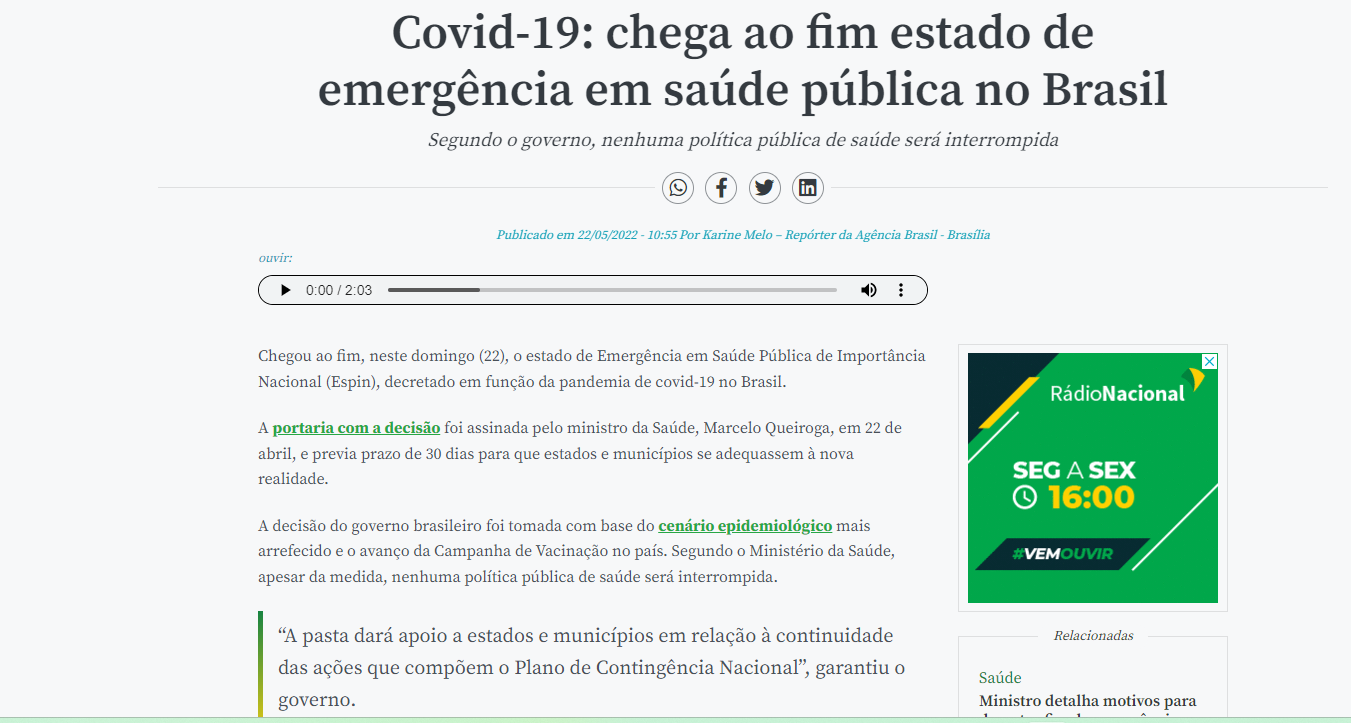


In [401]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-04-30           5107.93            78.52   
5            Sul 2023-04-29           5535.55            85.10   
9            Sul 2023-04-28           6023.56            92.60   
12           Sul 2023-04-27           6547.63           100.65   
17           Sul 2023-04-26           6861.46           105.48   
...          ...        ...               ...              ...   
26758   Nordeste 2005-01-05          11820.00            85.58   
26762   Nordeste 2005-01-04          11285.00            81.71   
26766   Nordeste 2005-01-03          10929.00            79.13   
26768   Nordeste 2005-01-02          10267.00            74.34   
26774   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4844.62                  74.47  20459.24    17191.60   
5                     5180.10                  79.6

In [402]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26776 entries, 1 to 26774
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              26776 non-null  object        
 1   Data                    26776 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        26776 non-null  float64       
 3   ENA_Bruta[%MLT]         26776 non-null  float64       
 4   ENA_Armazenavel[MWmed]  26776 non-null  float64       
 5   ENA_Armazenavel[%MLT]   26776 non-null  float64       
 6   EAR_max                 26776 non-null  float64       
 7   EAR[MWmes]              26776 non-null  float64       
 8   EAR[%max]               26776 non-null  float64       
 9   Carga_Diaria[MWmed]     26776 non-null  float64       
 10  CMO_semanal[R$/MWh]     26776 non-null  float64       
 11  CMO_leve[R$/MWh]        26776 non-null  float64       
 12  CMO_media[R$/MWh]       26776 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [403]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1492
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

## Visualizações Unimodais

### Histogramas

In [440]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

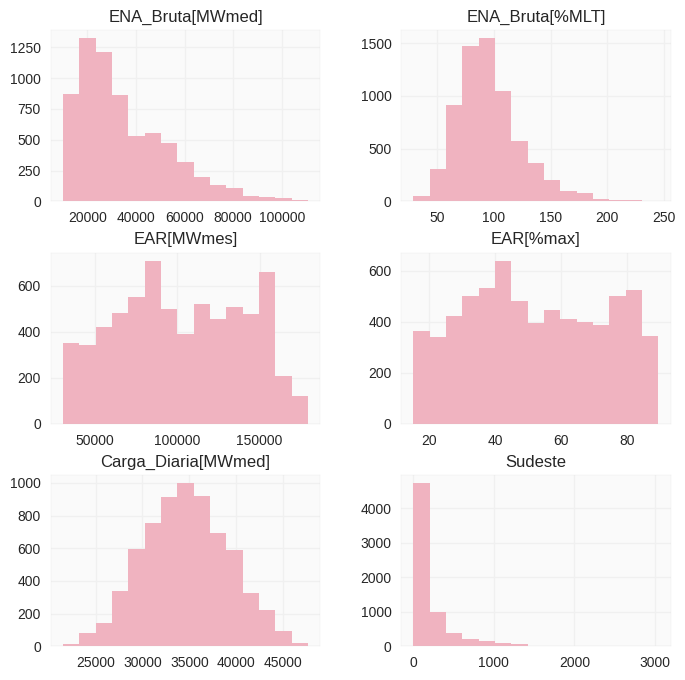

In [508]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,figsize = (8,8), color="#F0b3c0")
plt.title("Sudeste")
plt.show()

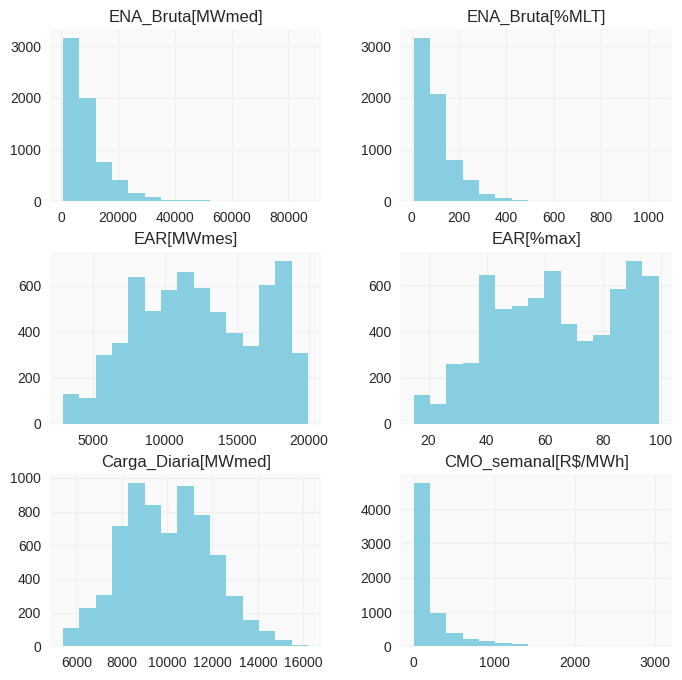

In [472]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,figsize = (8,8), color="#87cee0")
plt.show()

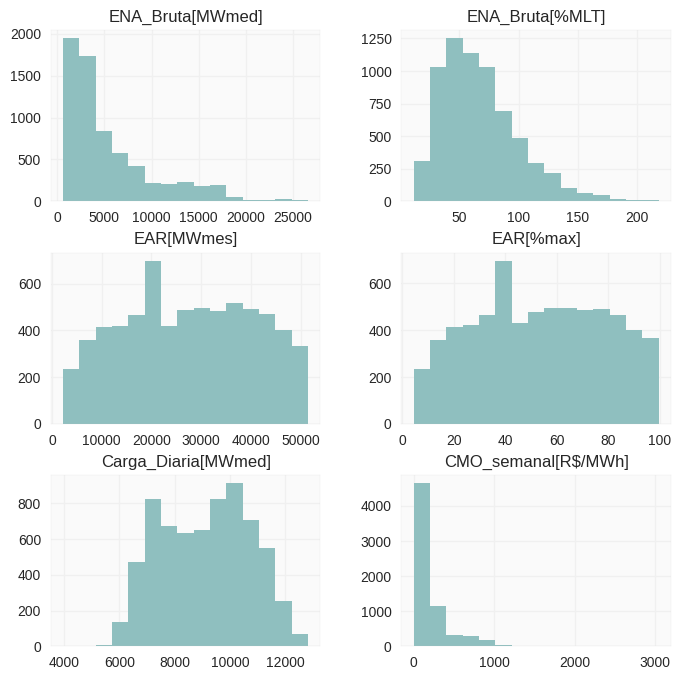

In [505]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,figsize = (8,8), color="#8FBfbF")
plt.show()

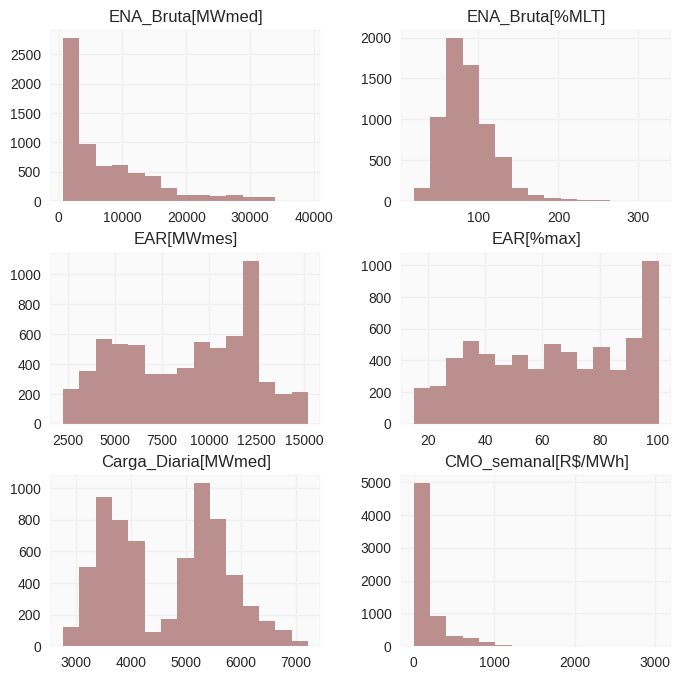

In [499]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,figsize = (8,8), color="#BC8F8F")
plt.show()

# Avaliações no Power BI

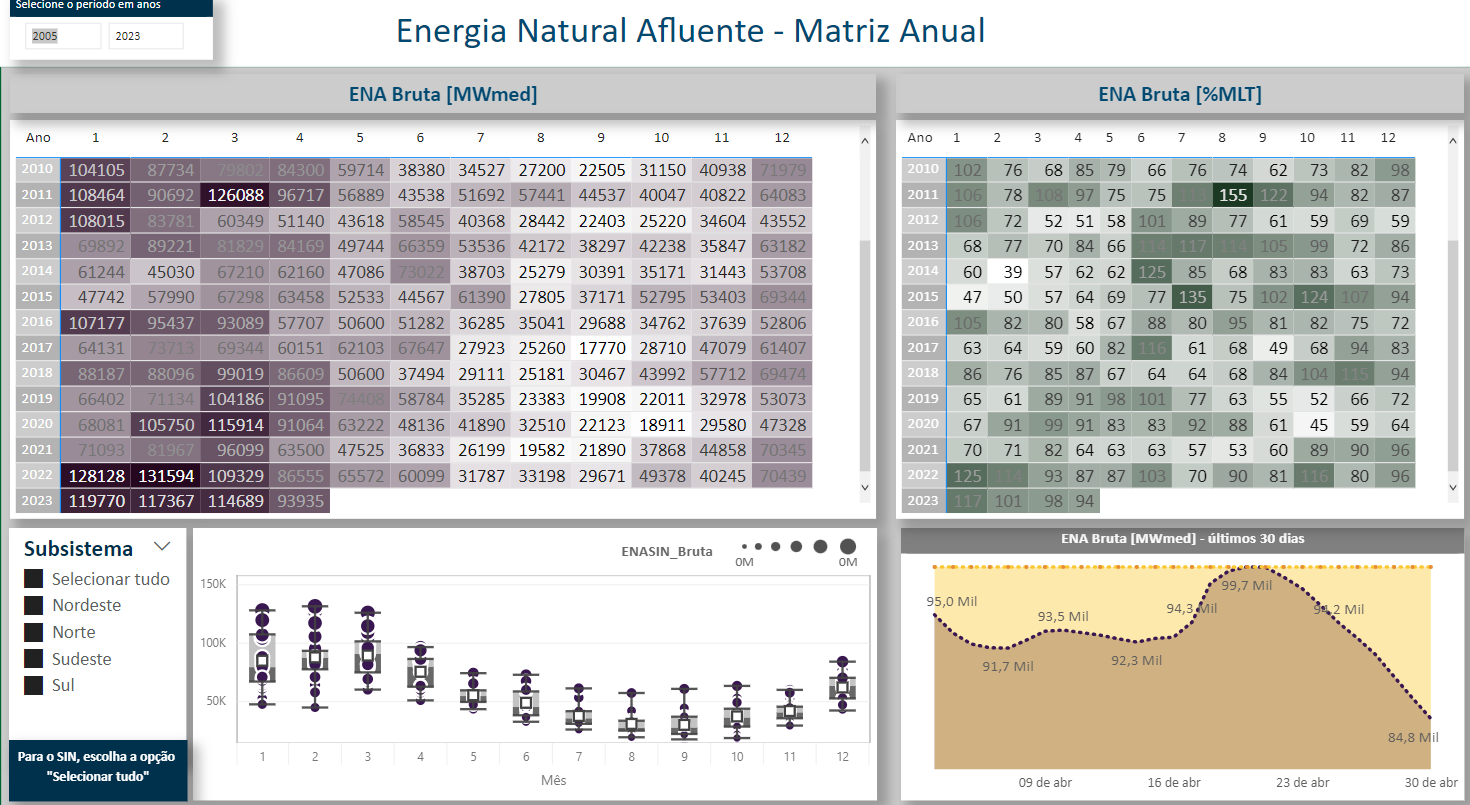